In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# ImageNet normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transformations with data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(
        size=224,
        scale=(0.9, 1.0),      # very mild crop
        ratio=(0.95, 1.05)
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.05,
        hue=0.02
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD
    )
])

# Validation and test transformations without augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD
    )
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        # Handle tissue type label encoding
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True
    )
    
    # Get the fitted encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le    

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/data/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/data/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/data/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [12]:
def create_xcit_model(num_classes=4, pretrained=True, model_type="tiny"):
    """
    Create XCiT (Cross-Covariance Image Transformer) Medium P16 model
    
    Args:
        num_classes (int): Number of output classes
        pretrained (bool): Whether to use pretrained weights
    
    Returns:
        model: XCiT Medium P16 model
    """
    
    model = timm.create_model(f'xcit_{model_type}_24_p16_224', pretrained=pretrained, num_classes=num_classes)
    
    return model

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train XCiT Tiny P16

Training XCiT Tiny P16


model.safetensors:   0%|          | 0.00/48.6M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=1.4005, Acc=0.3849]


Train Loss: 1.4005 Acc: 0.3849 Macro-F1: 0.3579


Val : 100%|██████████| 10/10 [00:01<00:00,  5.02it/s, Loss=1.1252, Acc=0.5000]


Val Loss: 1.1252 Acc: 0.5000 Macro-F1: 0.4387
✓ New best model saved with validation macro-F1: 0.4387

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, Loss=1.0668, Acc=0.5839]


Train Loss: 1.0668 Acc: 0.5839 Macro-F1: 0.5301


Val : 100%|██████████| 10/10 [00:01<00:00,  9.01it/s, Loss=1.3346, Acc=0.4737]


Val Loss: 1.3346 Acc: 0.4737 Macro-F1: 0.4326

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, Loss=0.9647, Acc=0.6349]


Train Loss: 0.9647 Acc: 0.6349 Macro-F1: 0.5746


Val : 100%|██████████| 10/10 [00:01<00:00,  8.75it/s, Loss=0.7852, Acc=0.6809]


Val Loss: 0.7852 Acc: 0.6809 Macro-F1: 0.6373
✓ New best model saved with validation macro-F1: 0.6373

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.73it/s, Loss=0.8472, Acc=0.6431]


Train Loss: 0.8472 Acc: 0.6431 Macro-F1: 0.5987


Val : 100%|██████████| 10/10 [00:01<00:00,  8.64it/s, Loss=0.5799, Acc=0.7599]


Val Loss: 0.5799 Acc: 0.7599 Macro-F1: 0.7320
✓ New best model saved with validation macro-F1: 0.7320

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, Loss=0.8277, Acc=0.6908]


Train Loss: 0.8277 Acc: 0.6908 Macro-F1: 0.6406


Val : 100%|██████████| 10/10 [00:01<00:00,  8.65it/s, Loss=0.5705, Acc=0.7895]


Val Loss: 0.5705 Acc: 0.7895 Macro-F1: 0.7653
✓ New best model saved with validation macro-F1: 0.7653

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, Loss=0.7679, Acc=0.7352]


Train Loss: 0.7679 Acc: 0.7352 Macro-F1: 0.6991


Val : 100%|██████████| 10/10 [00:01<00:00,  8.38it/s, Loss=0.8920, Acc=0.7138]


Val Loss: 0.8920 Acc: 0.7138 Macro-F1: 0.6671

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, Loss=0.6979, Acc=0.7574]


Train Loss: 0.6979 Acc: 0.7574 Macro-F1: 0.6979


Val : 100%|██████████| 10/10 [00:01<00:00,  8.93it/s, Loss=0.4110, Acc=0.8553]


Val Loss: 0.4110 Acc: 0.8553 Macro-F1: 0.8356
✓ New best model saved with validation macro-F1: 0.8356

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, Loss=0.4005, Acc=0.8791]


Train Loss: 0.4005 Acc: 0.8791 Macro-F1: 0.8564


Val : 100%|██████████| 10/10 [00:01<00:00,  8.79it/s, Loss=0.3302, Acc=0.8816]


Val Loss: 0.3302 Acc: 0.8816 Macro-F1: 0.8432
✓ New best model saved with validation macro-F1: 0.8432

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, Loss=0.3154, Acc=0.9021]


Train Loss: 0.3154 Acc: 0.9021 Macro-F1: 0.8803


Val : 100%|██████████| 10/10 [00:01<00:00,  8.76it/s, Loss=0.2907, Acc=0.9046]


Val Loss: 0.2907 Acc: 0.9046 Macro-F1: 0.8848
✓ New best model saved with validation macro-F1: 0.8848

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.75it/s, Loss=0.2636, Acc=0.9153]


Train Loss: 0.2636 Acc: 0.9153 Macro-F1: 0.8950


Val : 100%|██████████| 10/10 [00:01<00:00,  8.64it/s, Loss=0.1829, Acc=0.9375]


Val Loss: 0.1829 Acc: 0.9375 Macro-F1: 0.9213
✓ New best model saved with validation macro-F1: 0.9213

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, Loss=0.2479, Acc=0.9137]


Train Loss: 0.2479 Acc: 0.9137 Macro-F1: 0.8933


Val : 100%|██████████| 10/10 [00:01<00:00,  8.85it/s, Loss=0.4190, Acc=0.8553]


Val Loss: 0.4190 Acc: 0.8553 Macro-F1: 0.8110

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, Loss=0.2469, Acc=0.9169]


Train Loss: 0.2469 Acc: 0.9169 Macro-F1: 0.8986


Val : 100%|██████████| 10/10 [00:01<00:00,  8.93it/s, Loss=0.2295, Acc=0.9145]


Val Loss: 0.2295 Acc: 0.9145 Macro-F1: 0.8946

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, Loss=0.2031, Acc=0.9317]


Train Loss: 0.2031 Acc: 0.9317 Macro-F1: 0.9224


Val : 100%|██████████| 10/10 [00:01<00:00,  8.81it/s, Loss=0.2802, Acc=0.8914]


Val Loss: 0.2802 Acc: 0.8914 Macro-F1: 0.8668

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, Loss=0.2110, Acc=0.9301]


Train Loss: 0.2110 Acc: 0.9301 Macro-F1: 0.9166


Val : 100%|██████████| 10/10 [00:01<00:00,  8.73it/s, Loss=0.2500, Acc=0.9079]


Val Loss: 0.2500 Acc: 0.9079 Macro-F1: 0.8686

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:21<00:00,  1.76it/s, Loss=0.1814, Acc=0.9391]


Train Loss: 0.1814 Acc: 0.9391 Macro-F1: 0.9234


Val : 100%|██████████| 10/10 [00:01<00:00,  8.69it/s, Loss=0.1841, Acc=0.9408]


Val Loss: 0.1841 Acc: 0.9408 Macro-F1: 0.9135
Early stopping triggered after 15 epochs
Training complete in 5m 47s
Best validation macro-F1: 0.9213


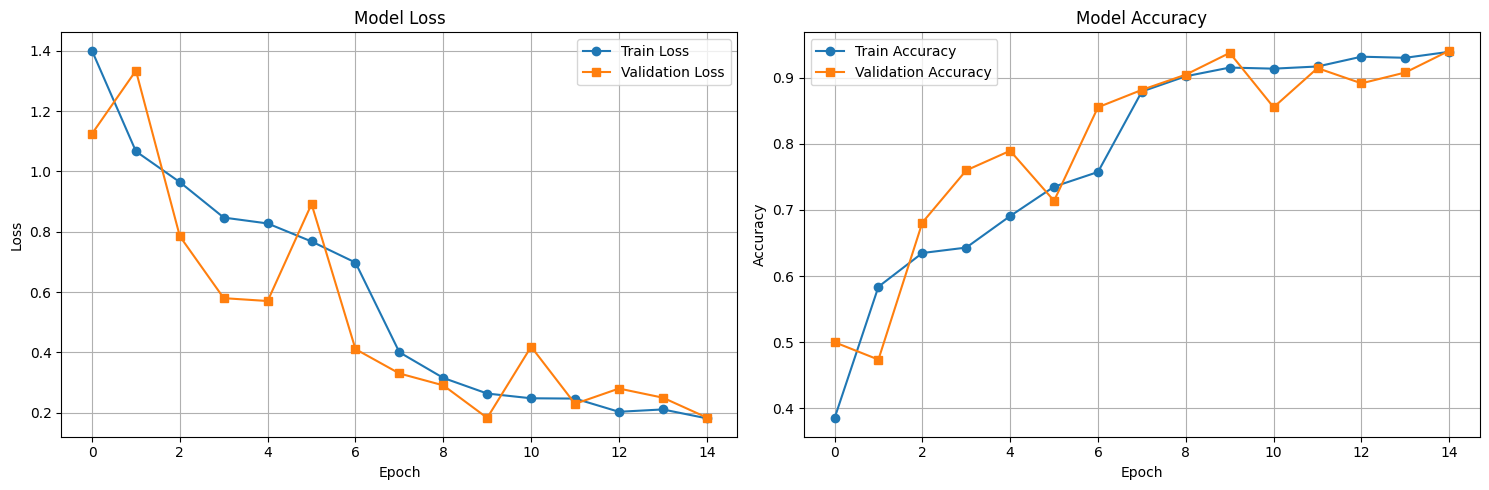

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


Test Accuracy: 57.67%
Test Loss: 1.3691

Classification Report:
              precision    recall  f1-score   support

         HGC       0.71      0.81      0.76        74
         LGC       0.63      0.36      0.46        53
         NST       0.52      0.68      0.59        37
         NTL       0.19      0.20      0.19        25

    accuracy                           0.58       189
   macro avg       0.51      0.51      0.50       189
weighted avg       0.58      0.58      0.57       189


Confusion Matrix:
[[60  8  5  1]
 [16 19  2 16]
 [ 6  1 25  5]
 [ 2  2 16  5]]

ROC-AUC Scores:
Macro-average AUC: 0.7602
Micro-average AUC: 0.8002
HGC AUC: 0.8505
LGC AUC: 0.6772
NST AUC: 0.8547
NTL AUC: 0.6585


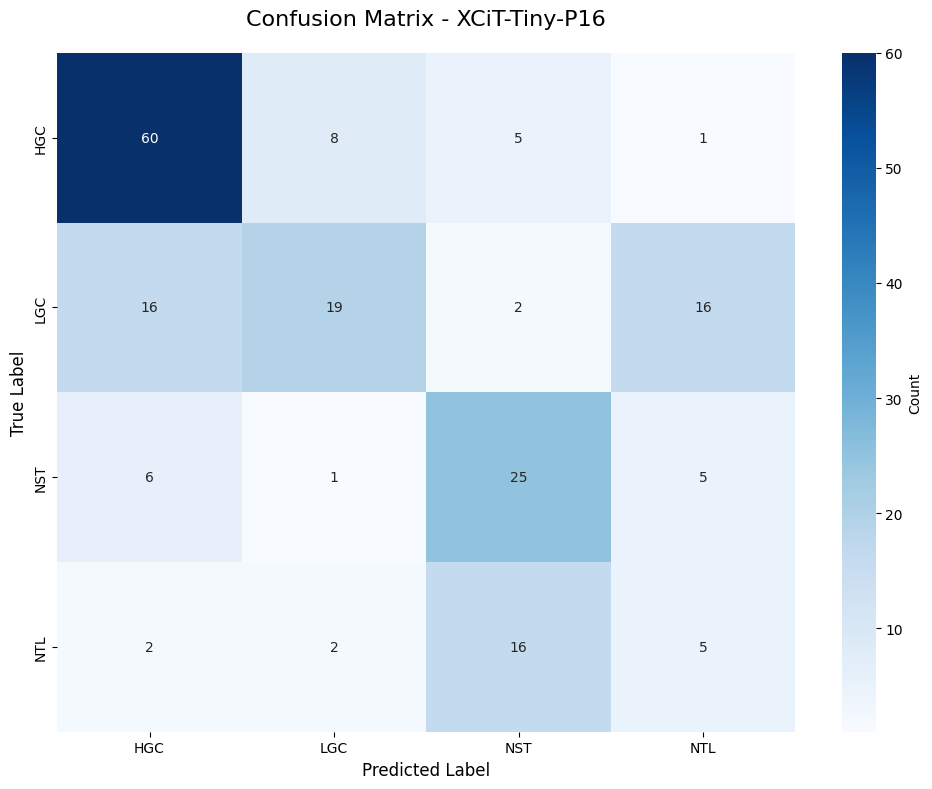

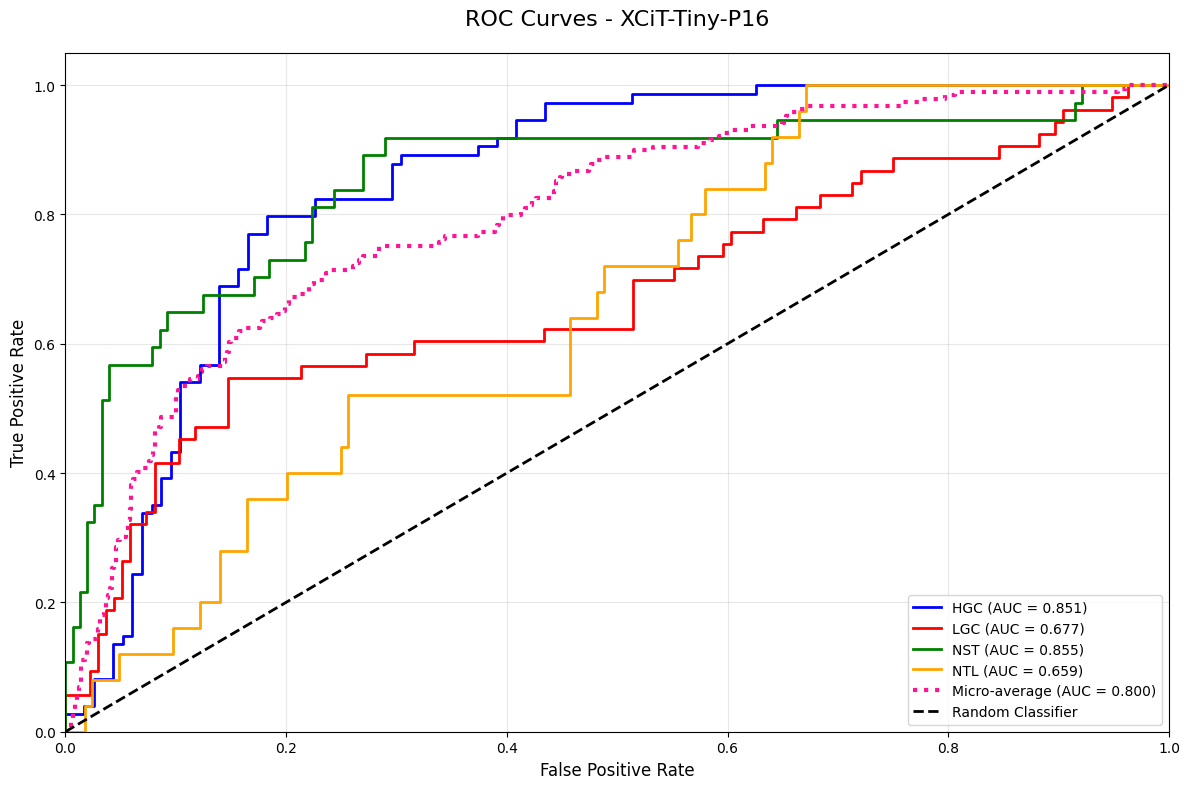


XCiT Tiny P16 training and evaluation complete!


In [16]:
print("=" * 80)
print("Training XCiT Tiny P16")
print("=" * 80)

# Create model
xcit_tiny = create_xcit_model(model_type='tiny', num_classes=4, pretrained=True)

# Create trainer
trainer_xcit_tiny = ModelTrainer(xcit_tiny, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_xcit_tiny = trainer_xcit_tiny.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="XCiT-Tiny-P16")

# Plot training history
trainer_xcit_tiny.plot_training_history(save_path='xcit_tiny_p16_training_history.png')

# Evaluate model
results_xcit_tiny = trainer_xcit_tiny.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_xcit_tiny['confusion_matrix'], class_names, 'XCiT-Tiny-P16',
                      save_path='xcit_tiny_p16_confusion_matrix.png')

# Plot ROC curves
roc_auc_xcit_tiny = plot_roc_curves(results_xcit_tiny['labels'], results_xcit_tiny['probabilities'], class_names, 'XCiT-Tiny-P16',
                                     save_path='xcit_tiny_p16_roc_curves.png')

# Store results
results_xcit_tiny['model_name'] = 'XCiT-Tiny-P16'
results_xcit_tiny['roc_auc'] = roc_auc_xcit_tiny
all_results.append(results_xcit_tiny)

print("\nXCiT Tiny P16 training and evaluation complete!")

## Train XCiT Small P16

Training XCiT Small P16


model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.20s/it, Loss=1.4398, Acc=0.2640]


Train Loss: 1.4398 Acc: 0.2640 Macro-F1: 0.2517


Val : 100%|██████████| 10/10 [00:02<00:00,  4.56it/s, Loss=1.1798, Acc=0.4770]


Val Loss: 1.1798 Acc: 0.4770 Macro-F1: 0.2938
✓ New best model saved with validation macro-F1: 0.2938

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:44<00:00,  1.18s/it, Loss=1.2951, Acc=0.3923]


Train Loss: 1.2951 Acc: 0.3923 Macro-F1: 0.3554


Val : 100%|██████████| 10/10 [00:01<00:00,  5.15it/s, Loss=1.0133, Acc=0.4967]


Val Loss: 1.0133 Acc: 0.4967 Macro-F1: 0.3541
✓ New best model saved with validation macro-F1: 0.3541

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.19s/it, Loss=1.1763, Acc=0.4868]


Train Loss: 1.1763 Acc: 0.4868 Macro-F1: 0.4016


Val : 100%|██████████| 10/10 [00:01<00:00,  5.11it/s, Loss=1.0635, Acc=0.4309]


Val Loss: 1.0635 Acc: 0.4309 Macro-F1: 0.3702
✓ New best model saved with validation macro-F1: 0.3702

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.19s/it, Loss=1.1199, Acc=0.4770]


Train Loss: 1.1199 Acc: 0.4770 Macro-F1: 0.4203


Val : 100%|██████████| 10/10 [00:01<00:00,  5.09it/s, Loss=0.9199, Acc=0.5132]


Val Loss: 0.9199 Acc: 0.5132 Macro-F1: 0.4404
✓ New best model saved with validation macro-F1: 0.4404

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.18s/it, Loss=1.0772, Acc=0.4885]


Train Loss: 1.0772 Acc: 0.4885 Macro-F1: 0.4530


Val : 100%|██████████| 10/10 [00:01<00:00,  5.10it/s, Loss=1.4624, Acc=0.3487]


Val Loss: 1.4624 Acc: 0.3487 Macro-F1: 0.2549

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.19s/it, Loss=1.0183, Acc=0.4827]


Train Loss: 1.0183 Acc: 0.4827 Macro-F1: 0.4472


Val : 100%|██████████| 10/10 [00:01<00:00,  5.11it/s, Loss=0.9347, Acc=0.4836]


Val Loss: 0.9347 Acc: 0.4836 Macro-F1: 0.4344

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.19s/it, Loss=1.0672, Acc=0.4671]


Train Loss: 1.0672 Acc: 0.4671 Macro-F1: 0.4446


Val : 100%|██████████| 10/10 [00:01<00:00,  5.11it/s, Loss=1.1891, Acc=0.3618]


Val Loss: 1.1891 Acc: 0.3618 Macro-F1: 0.2825

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.19s/it, Loss=0.9995, Acc=0.4786]


Train Loss: 0.9995 Acc: 0.4786 Macro-F1: 0.4156


Val : 100%|██████████| 10/10 [00:01<00:00,  5.07it/s, Loss=0.8859, Acc=0.5132]


Val Loss: 0.8859 Acc: 0.5132 Macro-F1: 0.4464
✓ New best model saved with validation macro-F1: 0.4464

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.19s/it, Loss=0.9029, Acc=0.5099]


Train Loss: 0.9029 Acc: 0.5099 Macro-F1: 0.4437


Val : 100%|██████████| 10/10 [00:01<00:00,  5.17it/s, Loss=0.8778, Acc=0.5099]


Val Loss: 0.8778 Acc: 0.5099 Macro-F1: 0.4796
✓ New best model saved with validation macro-F1: 0.4796

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.18s/it, Loss=0.8893, Acc=0.5502]


Train Loss: 0.8893 Acc: 0.5502 Macro-F1: 0.5236


Val : 100%|██████████| 10/10 [00:01<00:00,  5.12it/s, Loss=0.8747, Acc=0.4934]


Val Loss: 0.8747 Acc: 0.4934 Macro-F1: 0.4486

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.18s/it, Loss=0.8343, Acc=0.5164]


Train Loss: 0.8343 Acc: 0.5164 Macro-F1: 0.4629


Val : 100%|██████████| 10/10 [00:01<00:00,  5.04it/s, Loss=0.8649, Acc=0.5329]


Val Loss: 0.8649 Acc: 0.5329 Macro-F1: 0.5040
✓ New best model saved with validation macro-F1: 0.5040

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:44<00:00,  1.18s/it, Loss=0.8513, Acc=0.5304]


Train Loss: 0.8513 Acc: 0.5304 Macro-F1: 0.5090


Val : 100%|██████████| 10/10 [00:01<00:00,  5.09it/s, Loss=0.8058, Acc=0.5033]


Val Loss: 0.8058 Acc: 0.5033 Macro-F1: 0.4661

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:44<00:00,  1.18s/it, Loss=0.8039, Acc=0.5444]


Train Loss: 0.8039 Acc: 0.5444 Macro-F1: 0.5251


Val : 100%|██████████| 10/10 [00:01<00:00,  5.12it/s, Loss=0.7798, Acc=0.5164]


Val Loss: 0.7798 Acc: 0.5164 Macro-F1: 0.4815

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.19s/it, Loss=0.7592, Acc=0.5765]


Train Loss: 0.7592 Acc: 0.5765 Macro-F1: 0.5536


Val : 100%|██████████| 10/10 [00:01<00:00,  5.13it/s, Loss=0.8762, Acc=0.5855]


Val Loss: 0.8762 Acc: 0.5855 Macro-F1: 0.5409
✓ New best model saved with validation macro-F1: 0.5409

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.19s/it, Loss=0.6936, Acc=0.6382]


Train Loss: 0.6936 Acc: 0.6382 Macro-F1: 0.6075


Val : 100%|██████████| 10/10 [00:01<00:00,  5.09it/s, Loss=0.8034, Acc=0.5987]


Val Loss: 0.8034 Acc: 0.5987 Macro-F1: 0.5753
✓ New best model saved with validation macro-F1: 0.5753

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.19s/it, Loss=0.7303, Acc=0.6168]


Train Loss: 0.7303 Acc: 0.6168 Macro-F1: 0.5948


Val : 100%|██████████| 10/10 [00:01<00:00,  5.02it/s, Loss=0.7766, Acc=0.5789]


Val Loss: 0.7766 Acc: 0.5789 Macro-F1: 0.5514

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.19s/it, Loss=0.7313, Acc=0.6020]


Train Loss: 0.7313 Acc: 0.6020 Macro-F1: 0.5820


Val : 100%|██████████| 10/10 [00:01<00:00,  5.09it/s, Loss=0.7995, Acc=0.5888]


Val Loss: 0.7995 Acc: 0.5888 Macro-F1: 0.5650

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.18s/it, Loss=0.6876, Acc=0.6554]


Train Loss: 0.6876 Acc: 0.6554 Macro-F1: 0.6333


Val : 100%|██████████| 10/10 [00:01<00:00,  5.13it/s, Loss=0.7774, Acc=0.5789]


Val Loss: 0.7774 Acc: 0.5789 Macro-F1: 0.5529

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.19s/it, Loss=0.6637, Acc=0.6620]


Train Loss: 0.6637 Acc: 0.6620 Macro-F1: 0.6436


Val : 100%|██████████| 10/10 [00:01<00:00,  5.12it/s, Loss=0.7601, Acc=0.5921]


Val Loss: 0.7601 Acc: 0.5921 Macro-F1: 0.5685

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:45<00:00,  1.19s/it, Loss=0.6708, Acc=0.6423]


Train Loss: 0.6708 Acc: 0.6423 Macro-F1: 0.6243


Val : 100%|██████████| 10/10 [00:01<00:00,  5.02it/s, Loss=0.7805, Acc=0.5789]


Val Loss: 0.7805 Acc: 0.5789 Macro-F1: 0.5528
Early stopping triggered after 20 epochs
Training complete in 15m 45s
Best validation macro-F1: 0.5753


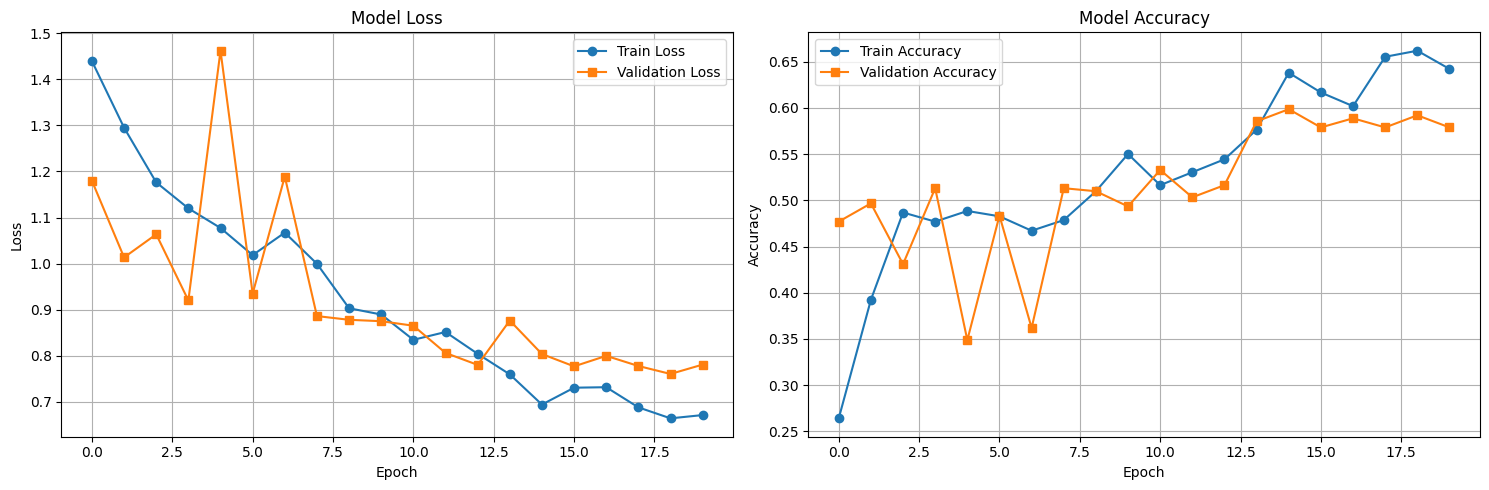

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


Test Accuracy: 39.15%
Test Loss: 1.4136

Classification Report:
              precision    recall  f1-score   support

         HGC       0.82      0.38      0.52        74
         LGC       0.18      0.09      0.12        53
         NST       0.49      0.89      0.63        37
         NTL       0.13      0.32      0.19        25

    accuracy                           0.39       189
   macro avg       0.41      0.42      0.37       189
weighted avg       0.49      0.39      0.39       189


Confusion Matrix:
[[28 23  9 14]
 [ 6  5  8 34]
 [ 0  0 33  4]
 [ 0  0 17  8]]

ROC-AUC Scores:
Macro-average AUC: 0.7244
Micro-average AUC: 0.7207
HGC AUC: 0.8783
LGC AUC: 0.5320
NST AUC: 0.9337
NTL AUC: 0.5537


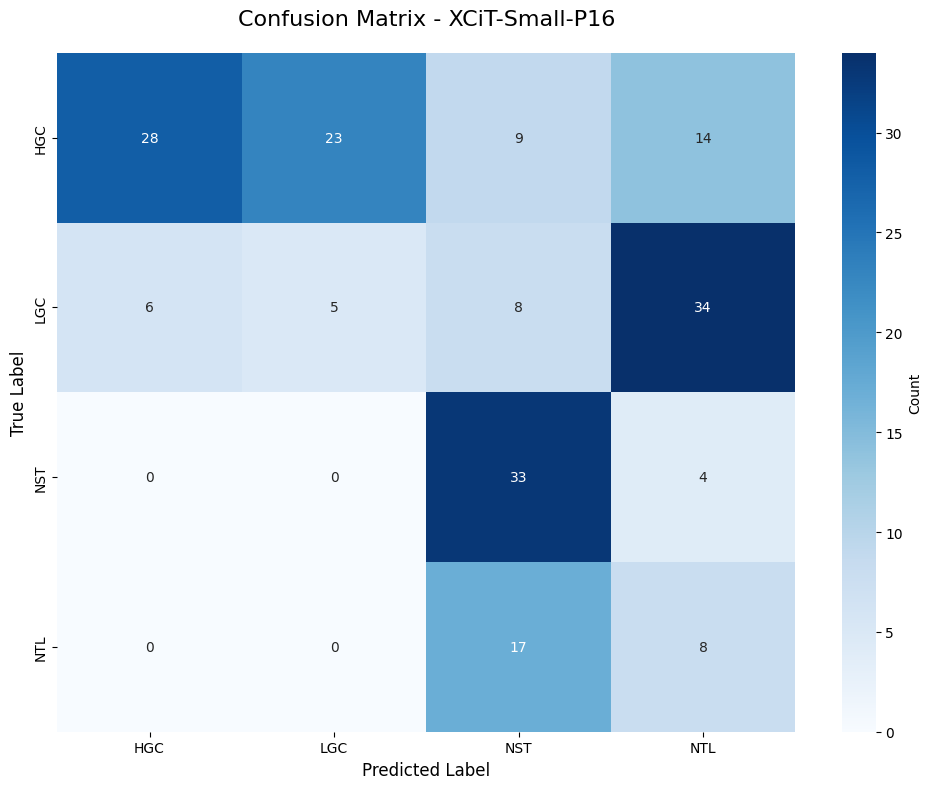

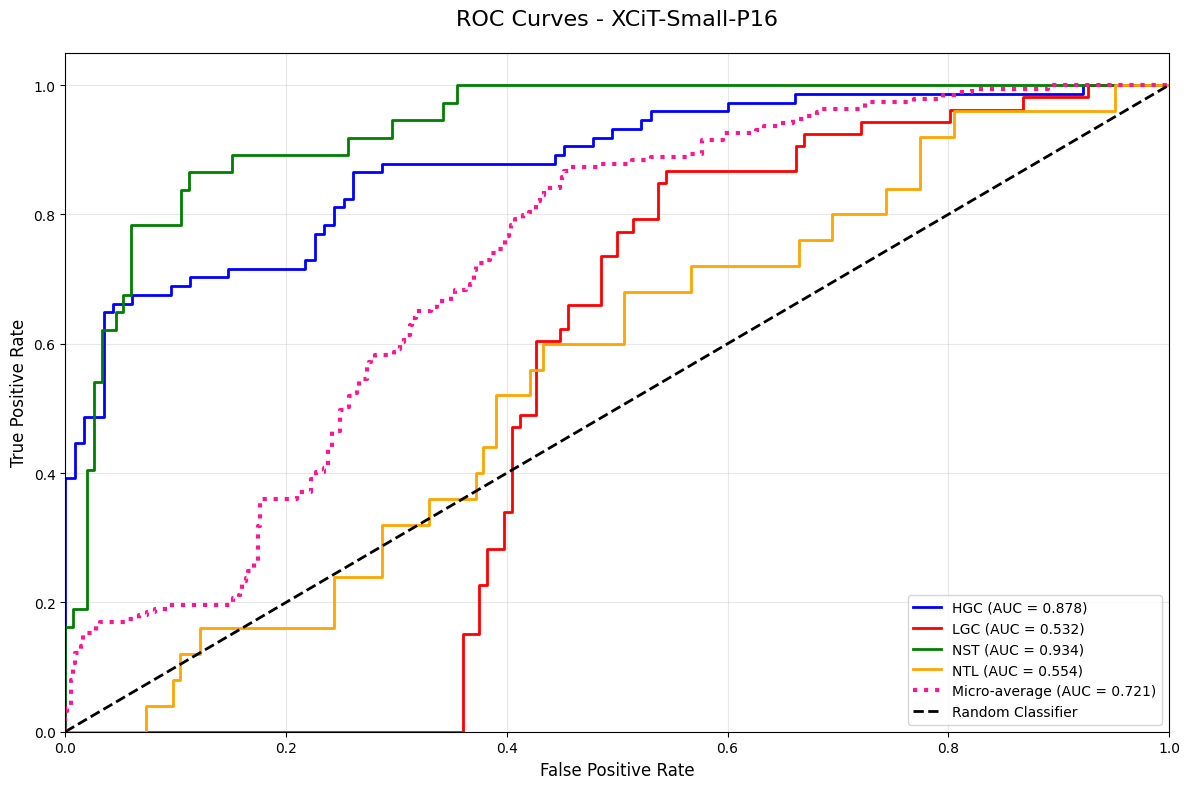


XCiT Small P16 training and evaluation complete!


In [17]:
print("=" * 80)
print("Training XCiT Small P16")
print("=" * 80)

# Create model
xcit_small = create_xcit_model(model_type='small', num_classes=4, pretrained=True)

# Create trainer
trainer_xcit_small = ModelTrainer(xcit_small, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_xcit_small = trainer_xcit_small.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="XCiT-Small-P16")

# Plot training history
trainer_xcit_small.plot_training_history(save_path='xcit_small_p16_training_history.png')

# Evaluate model
results_xcit_small = trainer_xcit_small.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_xcit_small['confusion_matrix'], class_names, 'XCiT-Small-P16',
                      save_path='xcit_small_p16_confusion_matrix.png')

# Plot ROC curves
roc_auc_xcit_small = plot_roc_curves(results_xcit_small['labels'], results_xcit_small['probabilities'], class_names, 'XCiT-Small-P16',
                                      save_path='xcit_small_p16_roc_curves.png')

# Store results
results_xcit_small['model_name'] = 'XCiT-Small-P16'
results_xcit_small['roc_auc'] = roc_auc_xcit_small
all_results.append(results_xcit_small)

print("\nXCiT Small P16 training and evaluation complete!")

## Train XCiT Medium P16

Training XCiT Medium P16


model.safetensors:   0%|          | 0.00/338M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [01:03<00:00,  1.67s/it, Loss=1.4651, Acc=0.2442]


Train Loss: 1.4651 Acc: 0.2442 Macro-F1: 0.2264


Val : 100%|██████████| 10/10 [00:02<00:00,  3.44it/s, Loss=1.3992, Acc=0.2763]


Val Loss: 1.3992 Acc: 0.2763 Macro-F1: 0.1082
✓ New best model saved with validation macro-F1: 0.1082

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.65s/it, Loss=1.4329, Acc=0.3092]


Train Loss: 1.4329 Acc: 0.3092 Macro-F1: 0.2775


Val : 100%|██████████| 10/10 [00:02<00:00,  3.71it/s, Loss=1.3836, Acc=0.2829]


Val Loss: 1.3836 Acc: 0.2829 Macro-F1: 0.1103
✓ New best model saved with validation macro-F1: 0.1103

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.65s/it, Loss=1.3960, Acc=0.2870]


Train Loss: 1.3960 Acc: 0.2870 Macro-F1: 0.2394


Val : 100%|██████████| 10/10 [00:02<00:00,  3.71it/s, Loss=1.4432, Acc=0.0724]


Val Loss: 1.4432 Acc: 0.0724 Macro-F1: 0.0337

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.65s/it, Loss=1.3975, Acc=0.2294]


Train Loss: 1.3975 Acc: 0.2294 Macro-F1: 0.2186


Val : 100%|██████████| 10/10 [00:02<00:00,  3.71it/s, Loss=1.3959, Acc=0.3750]


Val Loss: 1.3959 Acc: 0.3750 Macro-F1: 0.1992
✓ New best model saved with validation macro-F1: 0.1992

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.65s/it, Loss=1.3931, Acc=0.3446]


Train Loss: 1.3931 Acc: 0.3446 Macro-F1: 0.2550


Val : 100%|██████████| 10/10 [00:02<00:00,  3.68it/s, Loss=1.3909, Acc=0.3684]


Val Loss: 1.3909 Acc: 0.3684 Macro-F1: 0.1353

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.65s/it, Loss=1.3128, Acc=0.3890]


Train Loss: 1.3128 Acc: 0.3890 Macro-F1: 0.3197


Val : 100%|██████████| 10/10 [00:02<00:00,  3.70it/s, Loss=1.3313, Acc=0.2204]


Val Loss: 1.3313 Acc: 0.2204 Macro-F1: 0.1661

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.65s/it, Loss=1.2427, Acc=0.4712]


Train Loss: 1.2427 Acc: 0.4712 Macro-F1: 0.3980


Val : 100%|██████████| 10/10 [00:02<00:00,  3.68it/s, Loss=1.0471, Acc=0.5329]


Val Loss: 1.0471 Acc: 0.5329 Macro-F1: 0.3730
✓ New best model saved with validation macro-F1: 0.3730

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.65s/it, Loss=1.1966, Acc=0.4523]


Train Loss: 1.1966 Acc: 0.4523 Macro-F1: 0.3690


Val : 100%|██████████| 10/10 [00:02<00:00,  3.73it/s, Loss=1.0064, Acc=0.5230]


Val Loss: 1.0064 Acc: 0.5230 Macro-F1: 0.3619

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.65s/it, Loss=1.1045, Acc=0.4918]


Train Loss: 1.1045 Acc: 0.4918 Macro-F1: 0.3762


Val : 100%|██████████| 10/10 [00:02<00:00,  3.75it/s, Loss=0.9792, Acc=0.5033]


Val Loss: 0.9792 Acc: 0.5033 Macro-F1: 0.4099
✓ New best model saved with validation macro-F1: 0.4099

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.65s/it, Loss=1.0461, Acc=0.4975]


Train Loss: 1.0461 Acc: 0.4975 Macro-F1: 0.4181


Val : 100%|██████████| 10/10 [00:02<00:00,  3.71it/s, Loss=0.9871, Acc=0.4803]


Val Loss: 0.9871 Acc: 0.4803 Macro-F1: 0.3717

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.65s/it, Loss=1.0218, Acc=0.5033]


Train Loss: 1.0218 Acc: 0.5033 Macro-F1: 0.4362


Val : 100%|██████████| 10/10 [00:02<00:00,  3.70it/s, Loss=0.8558, Acc=0.6086]


Val Loss: 0.8558 Acc: 0.6086 Macro-F1: 0.5144
✓ New best model saved with validation macro-F1: 0.5144

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.66s/it, Loss=0.9982, Acc=0.5403]


Train Loss: 0.9982 Acc: 0.5403 Macro-F1: 0.4850


Val : 100%|██████████| 10/10 [00:02<00:00,  3.71it/s, Loss=0.9028, Acc=0.5691]


Val Loss: 0.9028 Acc: 0.5691 Macro-F1: 0.4882

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.65s/it, Loss=0.9964, Acc=0.5197]


Train Loss: 0.9964 Acc: 0.5197 Macro-F1: 0.4708


Val : 100%|██████████| 10/10 [00:02<00:00,  3.70it/s, Loss=0.8433, Acc=0.5954]


Val Loss: 0.8433 Acc: 0.5954 Macro-F1: 0.4799

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.66s/it, Loss=0.9775, Acc=0.5567]


Train Loss: 0.9775 Acc: 0.5567 Macro-F1: 0.5007


Val : 100%|██████████| 10/10 [00:02<00:00,  3.75it/s, Loss=0.8516, Acc=0.5789]


Val Loss: 0.8516 Acc: 0.5789 Macro-F1: 0.5054

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.65s/it, Loss=0.9078, Acc=0.5962]


Train Loss: 0.9078 Acc: 0.5962 Macro-F1: 0.5489


Val : 100%|██████████| 10/10 [00:02<00:00,  3.73it/s, Loss=0.8709, Acc=0.5691]


Val Loss: 0.8709 Acc: 0.5691 Macro-F1: 0.5022

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.66s/it, Loss=0.9068, Acc=0.6053]


Train Loss: 0.9068 Acc: 0.6053 Macro-F1: 0.5485


Val : 100%|██████████| 10/10 [00:02<00:00,  3.70it/s, Loss=0.8821, Acc=0.5493]


Val Loss: 0.8821 Acc: 0.5493 Macro-F1: 0.4897
Early stopping triggered after 16 epochs
Training complete in 17m 34s
Best validation macro-F1: 0.5144


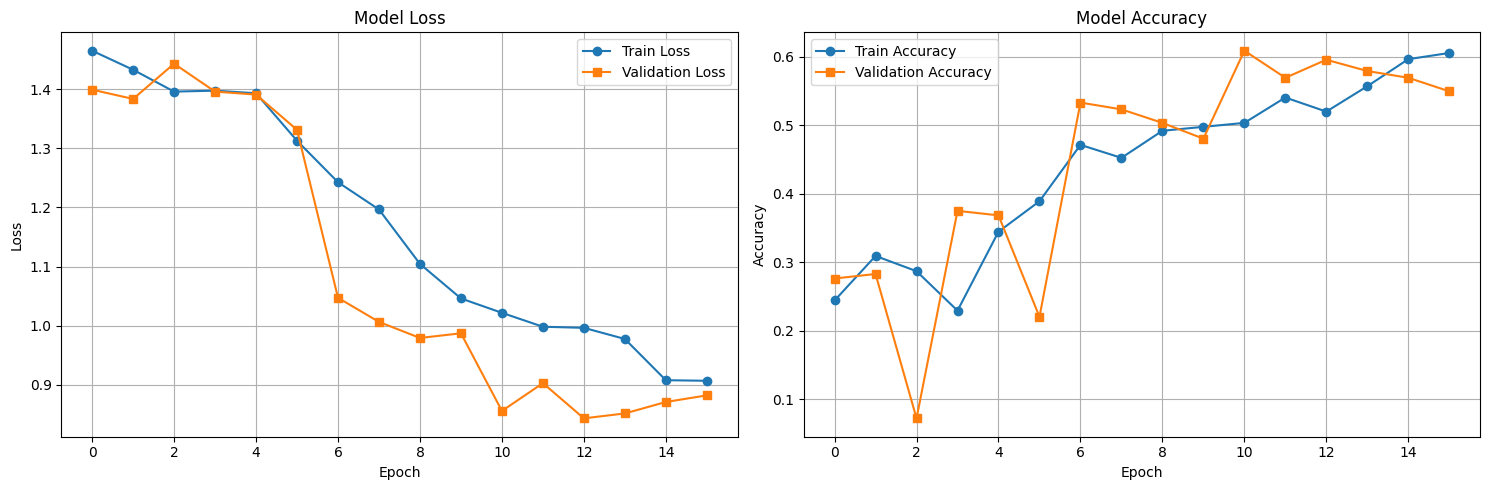

Evaluating on test set...


100%|██████████| 6/6 [00:02<00:00,  2.79it/s]


Test Accuracy: 29.63%
Test Loss: 1.4575

Classification Report:
              precision    recall  f1-score   support

         HGC       0.31      0.20      0.24        74
         LGC       0.00      0.00      0.00        53
         NST       0.41      0.51      0.46        37
         NTL       0.40      0.88      0.55        25

    accuracy                           0.30       189
   macro avg       0.28      0.40      0.31       189
weighted avg       0.25      0.30      0.26       189


Confusion Matrix:
[[15 39 12  8]
 [30  0 14  9]
 [ 2  0 19 16]
 [ 2  0  1 22]]

ROC-AUC Scores:
Macro-average AUC: 0.6998
Micro-average AUC: 0.6707
HGC AUC: 0.6537
LGC AUC: 0.4625
NST AUC: 0.7749
NTL AUC: 0.9080


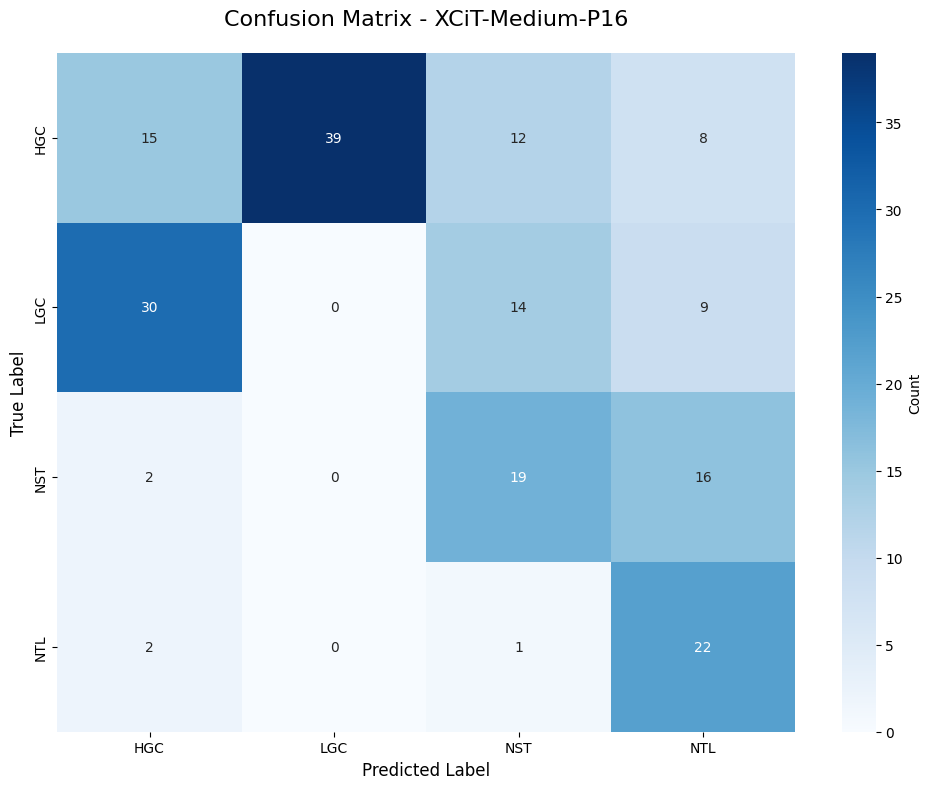

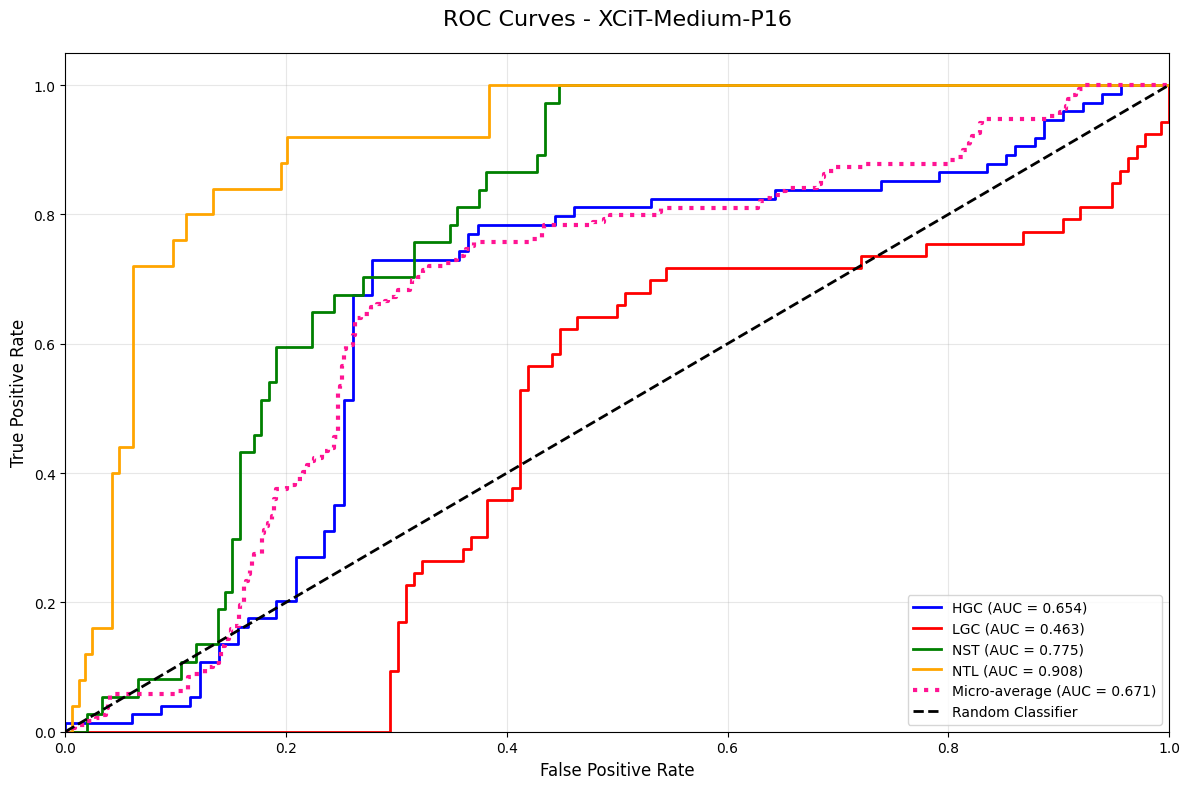


XCiT Medium P16 training and evaluation complete!


In [18]:
print("=" * 80)
print("Training XCiT Medium P16")
print("=" * 80)

# Create model
xcit_medium = create_xcit_model(model_type='medium', num_classes=4, pretrained=True)

# Create trainer
trainer_xcit_medium = ModelTrainer(xcit_medium, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_xcit_medium = trainer_xcit_medium.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="XCiT-Medium-P16")

# Plot training history
trainer_xcit_medium.plot_training_history(save_path='xcit_medium_p16_training_history.png')

# Evaluate model
results_xcit_medium = trainer_xcit_medium.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_xcit_medium['confusion_matrix'], class_names, 'XCiT-Medium-P16',
                      save_path='xcit_medium_p16_confusion_matrix.png')

# Plot ROC curves
roc_auc_xcit_medium = plot_roc_curves(results_xcit_medium['labels'], results_xcit_medium['probabilities'], class_names, 'XCiT-Medium-P16',
                                       save_path='xcit_medium_p16_roc_curves.png')

# Store results
results_xcit_medium['model_name'] = 'XCiT-Medium-P16'
results_xcit_medium['roc_auc'] = roc_auc_xcit_medium
all_results.append(results_xcit_medium)

print("\nXCiT Medium P16 training and evaluation complete!")

# Save All Metrics to CSV

In [19]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'XCiT_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: XCiT_metrics.csv

Metrics Summary:
             Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0    XCiT-Tiny-P16         57.671958      1.369128             0.513409          0.511244      0.499467                0.583726             0.576720         0.566349       0.714286    0.810811  0.759494         74.0       0.633333    0.358491  0.457831         53.0       0.520833    0.675676  0.588235         37.0       0.185185        0.20  0.192308         25.0   0.760240   0.800248  0.850529  0.677164  0.854730  0.658537      0.850529 